In [64]:
import json
import os
import pandas as pd


* *LOAD REAL & GENERATED 10 MINUTES NETWORK TRAFFIC*

In [65]:
generated_traffic = []
with open('..\Generated_ZigBee_Packets\extracted_packets.json', 'r') as f:
    generated_traffic = json.load(f)

<>:2: SyntaxWarning: invalid escape sequence '\G'
<>:2: SyntaxWarning: invalid escape sequence '\G'
C:\Users\nkelesoglu\AppData\Local\Temp\ipykernel_15132\3556405922.py:2: SyntaxWarning: invalid escape sequence '\G'
  with open('..\Generated_ZigBee_Packets\extracted_packets.json', 'r') as f:


In [66]:
generated_traffic = pd.DataFrame(generated_traffic)
generated_traffic.head(2)

,time,src,dst,protocol,length,info
0,5.321564,0x1de6,0xfffc,ZigBee,80,Link Status
1,11.251802,0xd7a7,0x1de6,ZigBee HA,56,"ZCL: Read Attributes, Seq: 11"


In [67]:
real_traffic = []
with open(r'../Datasets/Experiment_2_input_sample.json', 'r') as file:
    for line in file:
        real_traffic.append(json.loads(line))

print(real_traffic )

[{'No.': 46, 'Time': 3.486046, 'Source': '0x1de6', 'Destination': 'Broadcast', 'Protocol': 'ZigBee', 'Length': 80, 'Info': 'Link Status', 'Info_clean': 'Link Status'}, {'No.': 177, 'Time': 11.472175, 'Source': '0xd7a7', 'Destination': '0x1de6', 'Protocol': 'ZigBee HA', 'Length': 56, 'Info': 'ZCL: Read Attributes, Seq: 216', 'Info_clean': 'ZCL: Read Attributes,'}, {'No.': 179, 'Time': 11.50384, 'Source': '0xd7a7', 'Destination': '0x1de6', 'Protocol': 'ZigBee HA', 'Length': 52, 'Info': 'ZCL: Read Attributes, Seq: 217', 'Info_clean': 'ZCL: Read Attributes,'}, {'No.': 181, 'Time': 11.527324, 'Source': '0x1de6', 'Destination': '0xd7a7', 'Protocol': 'ZigBee HA', 'Length': 69, 'Info': 'ZCL: Read Attributes Response, Seq: 216', 'Info_clean': 'ZCL: Read Attributes Response,'}, {'No.': 185, 'Time': 11.559638, 'Source': '0x1de6', 'Destination': '0xd7a7', 'Protocol': 'ZigBee HA', 'Length': 61, 'Info': 'ZCL: Read Attributes Response, Seq: 217', 'Info_clean': 'ZCL: Read Attributes Response,'}, {'No.

In [68]:
real_traffic  = pd.DataFrame(real_traffic )
real_traffic.head(2)

,No.,Time,Source,Destination,Protocol,Length,Info,Info_clean
0,46,3.486046,0x1de6,Broadcast,ZigBee,80,Link Status,Link Status
1,177,11.472175,0xd7a7,0x1de6,ZigBee HA,56,"ZCL: Read Attributes, Seq: 216","ZCL: Read Attributes,"


In [69]:
real_traffic = real_traffic.drop(columns=["No.", "Info_clean"])
real_traffic.head(2)

,Time,Source,Destination,Protocol,Length,Info
0,3.486046,0x1de6,Broadcast,ZigBee,80,Link Status
1,11.472175,0xd7a7,0x1de6,ZigBee HA,56,"ZCL: Read Attributes, Seq: 216"


In [70]:
generated_traffic.head(2)

,time,src,dst,protocol,length,info
0,5.321564,0x1de6,0xfffc,ZigBee,80,Link Status
1,11.251802,0xd7a7,0x1de6,ZigBee HA,56,"ZCL: Read Attributes, Seq: 11"


* *FUNDAMENTAL STATISTICS*

In [71]:
generated_traffic['time']

0        5.321564
1       11.251802
2       11.282317
3       11.305911
4       11.329670
          ...    
199    567.410691
200    567.443240
201    567.467921
202    567.490381
203    588.411637
Name: time, Length: 204, dtype: object

In [72]:
print(f"\n--- REAL TRAFFIC ---")
print("Number of Packet:", len(real_traffic))
print("Average Packet Size:", real_traffic['Length'].mean())
print("Time Interval Average:", real_traffic['Time'].diff().mean())
print("Time Interval min:", real_traffic['Time'].diff().min())
print("Time Interval max:", real_traffic['Time'].diff().max())

print("Number of source:", real_traffic['Source'].nunique())
print("Number of destination:", real_traffic['Destination'].nunique())

print(f"\n--- GENERATED TRAFFIC ---")
print("Number of Packet:", len(generated_traffic))
print("Average Packet Size:", (generated_traffic['length'].astype(int)).mean())
print("Time Interval Average:", (generated_traffic['time'].astype(float)).diff().mean())
print("Time Interval min:", (generated_traffic['time'].astype(float)).diff().min())
print("Time Interval max:", (generated_traffic['time'].astype(float)).diff().max())
print("Number of source:", generated_traffic['src'].nunique())
print("Number of destination:", generated_traffic['dst'].nunique())




--- REAL TRAFFIC ---
Number of Packet: 220
Average Packet Size: 62.527272727272724
Time Interval Average: 2.6847511826484016
Time Interval min: 0.00524799999999459
Time Interval max: 16.249922999999995
Number of source: 2
Number of destination: 3

--- GENERATED TRAFFIC ---
Number of Packet: 204
Average Packet Size: 63.029411764705884
Time Interval Average: 2.872364891625616
Time Interval min: 0.0166370000000029
Time Interval max: 20.921256000000085
Number of source: 2
Number of destination: 3


* *SIMILARITY METRICS - JENSEN SHANNON FUNCTION*

In [73]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import MinMaxScaler

def distribution_similarity(real_traffic, gen_traffic, bins=10):

    # Normalization and Histogram
    real_hist, _ = np.histogram(real_traffic, bins=bins, density=True)
    gen_hist, _ = np.histogram(gen_traffic, bins=bins, density=True)

    # Prevent zeros by adding lower case numbers
    """Jensen-Shannon Divergence can have problems with histograms containing zeros (log(0) is undefined). 
    Therefore, a small number (1e-9) is added to the histograms to remove the zeros."""
    real_hist += 1e-9
    gen_hist += 1e-9

    # Similarity Calculation
    """Jensen-Shannon Divergence (JSD): Measures the similarity between two probability distributions 
    (0: exactly the same, 1: completely different)."""
    js = jensenshannon(real_hist, gen_hist)

    return js


In [74]:
""" JENSEN SHANNON FOR PACKET SIZE"""

generated_traffic['length'] = pd.to_numeric( generated_traffic['length'], errors='coerce')
real_traffic['Length'] = pd.to_numeric(real_traffic['Length'], errors='coerce')

js_packet = distribution_similarity(real_traffic['Length'], generated_traffic['length'])
print(f"\nJensen-Shannon for package size: {js_packet:.4f}")

""" JENSEN SHANNON FOR TIMESTAMPT"""

generated_traffic['time'] = pd.to_numeric( generated_traffic['time'], errors='coerce')
real_traffic['Time'] = pd.to_numeric(real_traffic['Time'], errors='coerce')

js_packet = distribution_similarity(real_traffic['Time'], generated_traffic['time'] )
print(f"\nJensen-Shannon for time: {js_packet:.4f}")


Jensen-Shannon for package size: 0.0657

Jensen-Shannon for time: 0.1098


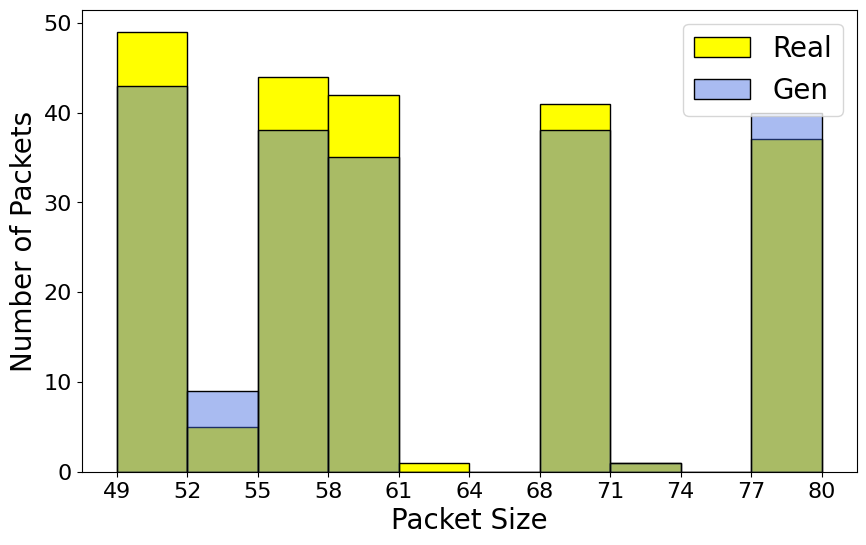

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution_with_js(real_traffic, gen_traffic, bins=10):

    js = distribution_similarity(real_traffic, gen_traffic, bins)

    plt.figure(figsize=(10, 6))

    min_val = min(real_traffic.min(), gen_traffic.min())
    max_val = max(real_traffic.max(), gen_traffic.max())
    bin_edges = np.linspace(min_val, max_val, bins + 1)
    
    sns.histplot(real_traffic, bins=bins, color="yellow", stat='count', label='Real',  alpha=1)
    sns.histplot(gen_traffic, bins=bins, color="royalblue", stat='count', label='Gen',   alpha=0.45)

    #plt.title(f"Distribution Comparison in terms of Packet Size\nJensen-Shannon = {js:.4f}", fontsize = 20)
    plt.xlabel("Packet Size", fontsize = 20)
    plt.ylabel("Number of Packets", fontsize = 20)
    plt.legend(fontsize=20)
    #plt.grid(True)
    #plt.tight_layout()
    plt.xticks(bin_edges, labels=[f"{edge:.0f}" for edge in bin_edges], fontsize=16)
    plt.yticks(fontsize=16)   
    plt.savefig(r'..\Experiment_2\Results-Figures/exp2_JSD_packet_size.png', bbox_inches='tight')
    plt.show()


plot_distribution_with_js(real_traffic['Length'], generated_traffic['length'])



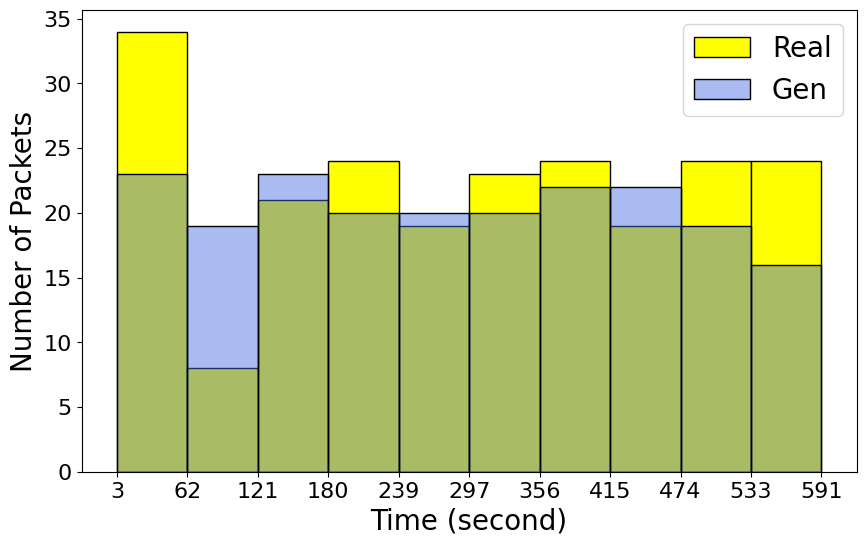

In [76]:
def plot_distribution_with_js(real_traffic, gen_traffic, bins=10):

    js = distribution_similarity(real_traffic, gen_traffic, bins)

    plt.figure(figsize=(10, 6))

    min_val = min(real_traffic.min(), gen_traffic.min())
    max_val = max(real_traffic.max(), gen_traffic.max())
    bin_edges = np.linspace(min_val, max_val, bins + 1)

    sns.histplot(real_traffic, bins=bin_edges, color="yellow", stat='count', label='Real',  alpha=1)
    sns.histplot(gen_traffic, bins=bin_edges, color="royalblue", stat='count', label='Gen',   alpha=0.45)

    #plt.title(f"Distribution Comparison in terms of Time\nJensen-Shannon = {js:.4f}", fontsize = 20)
    plt.xlabel("Time (second)", fontsize = 20)
    plt.ylabel("Number of Packets", fontsize = 20)
    plt.legend(fontsize=20)
    #plt.grid(True)
    #plt.tight_layout()
    plt.xticks(bin_edges, labels=[f"{edge:.0f}" for edge in bin_edges], fontsize=16)
    plt.yticks(fontsize=16)
    plt.savefig(r'..\Experiment_2\Results-Figures/exp2_JSD_time.png', bbox_inches='tight')
    plt.show()

plot_distribution_with_js(real_traffic['Time'], generated_traffic['time'] )
